In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

education_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

# fill in the missing values

In [5]:
fill_list = ["ENROLL", "TOTAL_REVENUE", "FEDERAL_REVENUE", 
             "STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE", 
             "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G", 
             "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", "GRADES_12_G", "GRADES_1_8_G", 
             "GRADES_9_12_G", "GRADES_ALL_G","AVG_MATH_4_SCORE","AVG_MATH_8_SCORE",
             "AVG_READING_4_SCORE","AVG_READING_8_SCORE"]

states = education_df["STATE"].unique()

for state in states:
    education_df.loc[education_df["STATE"] == state, fill_list] = education_df.loc[education_df["STATE"] == state, fill_list].interpolate()

# we drop the null values after interpolation
education_df.dropna(inplace=True)

# 1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?

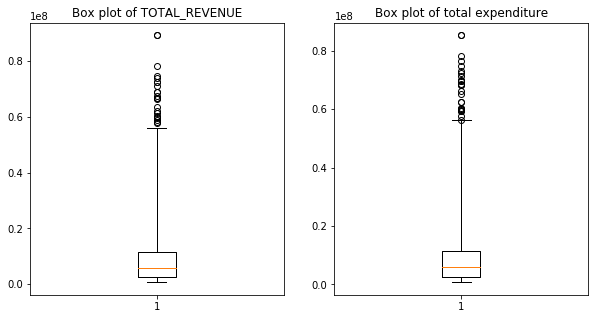

In [6]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.boxplot(education_df["TOTAL_REVENUE"], whis = 5)
plt.title("Box plot of TOTAL_REVENUE")

plt.subplot(1,2,2)
plt.boxplot(education_df["TOTAL_EXPENDITURE"], whis = 5)
plt.title("Box plot of total expenditure")
plt.show()

The two variables TOTAL_REVENUE and TOTAL_EXPENDITURE have outlier values.

# 2. If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

By using winsorization to eliminate the outliers, we need to create two new variables w_revenue and w_expenditure.

In [8]:
from scipy.stats.mstats import winsorize

w_revenue = winsorize(education_df["TOTAL_REVENUE"], (0, 0.05))

w_expenditure = winsorize(education_df["TOTAL_EXPENDITURE"], (0, 0.05))

Using boxplot to see whether they also have outlier values.

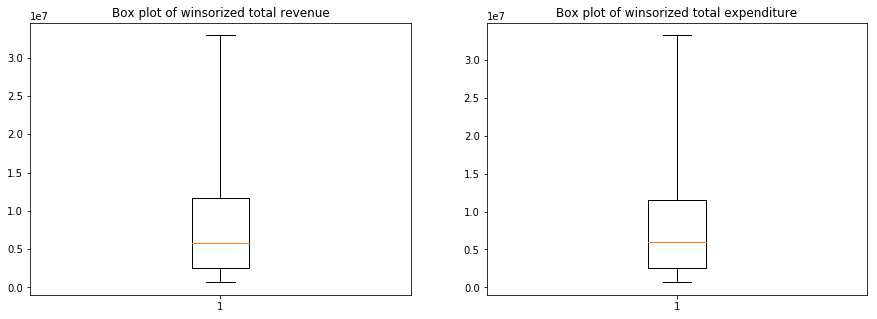

In [9]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(w_revenue, whis = 5)
plt.title("Box plot of winsorized total revenue")

plt.subplot(1,2,2)
plt.boxplot(w_expenditure, whis = 5)
plt.title("Box plot of winsorized total expenditure")
plt.show()

There are no outlier values now.

# 3. Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

In [10]:
# Creat new variable
budget_deficit = education_df.TOTAL_REVENUE - education_df.TOTAL_EXPENDITURE

Text(0.5,1,'Box plot of budget deficit')

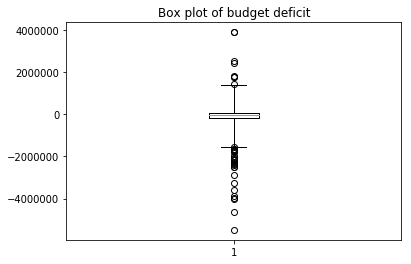

In [11]:
# see whether have outlier values.
plt.boxplot(budget_deficit, whis = 5)
plt.title("Box plot of budget deficit")

In [13]:
# Using winsorization to eliminate the outliers.
w_budget = winsorize(budget_deficit, (0.05, 0.05))

Text(0.5,1,'Box plot of budget deficit')

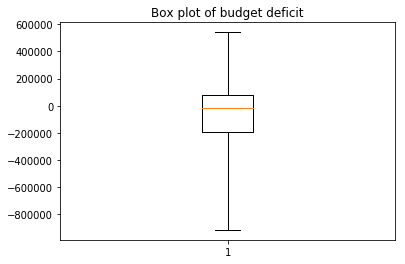

In [15]:
plt.boxplot(w_budget, whis = 5)
plt.title("Box plot of budget deficit")

There are no outlier values now.

# 4. Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.

In [17]:
# Creat new variable
budget_deficit2 = w_revenue - w_expenditure

Text(0.5,1,'Box plot of budget deficit 2')

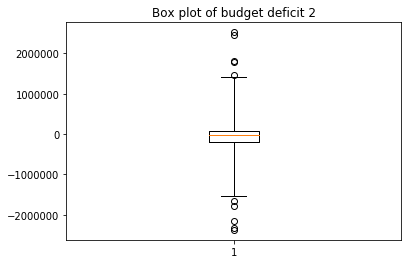

In [18]:
plt.boxplot(budget_deficit2, whis = 5)
plt.title("Box plot of budget deficit 2")

Text(0.5,1,'Box plot of budget deficit 2')

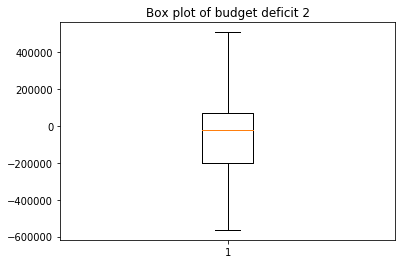

In [19]:
w_budget2 = winsorize(budget_deficit2, (0.05, 0.05))
plt.boxplot(w_budget2, whis = 5)
plt.title("Box plot of budget deficit 2")

# 5. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?

In [20]:
pd.DataFrame({"original_budget": budget_deficit, "winsorized_budget1": w_budget,
              "winsorized_budget2": w_budget2}).describe()

,original_budget,winsorized_budget1,winsorized_budget2
count,1.046000e+03,1046.000000,1046.000000
mean,-8.971628e+04,-67121.217017,-42953.404398
std,6.065230e+05,324443.529605,251843.508358
min,-5.487742e+06,-913765.000000,-563852.000000
25%,-1.949450e+05,-194945.000000,-202135.250000
50%,-1.583400e+04,-15834.000000,-20112.500000
75%,7.736350e+04,77363.500000,72142.000000
max,3.897129e+06,540772.000000,508361.000000


For almost all key statistics, these two variables are totally different. This means that eliminating outliers is important to the dataset. and may improve the accuracy of the data. 

# 6. If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question? 

Eliminating the outliers may help us,but sometimes not. So, it's better to  create a new variable from the originals and then to apply outlier elimination techniques next. Then compare whether eliminating the outliers is better. Hence, the approach in the third question is better,